In [1]:
import numpy as np
import pandas as pd
from glob import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import os
from tensorflow.keras import layers, models
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [3]:
df = pd.read_csv ('./dataset/HandInfo.csv')

In [4]:
files = glob('./dataset/Hands/*.jpg')
list_images = []
img_size = 256

for file in files:
    path_file = file.replace("\\","/");
    filename = path_file.split("/")[3]
    img = cv2.cvtColor(cv2.imread(path_file), cv2.COLOR_BGR2RGB)
    resized_img = cv2.resize(img, (img_size, img_size))
    list_images.append([resized_img, df[df['imageName'] == filename].filter(items = ['gender']).values[0][0]])
    

In [5]:
random.shuffle(list_images)
data = np.array(list_images)

C:\Users\danie\AppData\Local\Temp/ipykernel_18264/3997491373.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(list_images)


C:\Users\danie\Programas\miniconda3\envs\img\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Dataset')

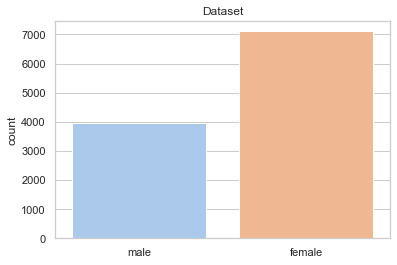

In [6]:
classes = []
m = 0
f = 0
for i in data:
    if(i[1] == 'male'):
        classes.append("male")
        m = m + 1
    else:
        classes.append("female")
        f = f + 1
sns.set_theme(style="whitegrid", palette="pastel")
sns.countplot(classes).set_title("Dataset")

In [7]:
print("Male {} | Female {}".format(m,f))

Male 3967 | Female 7109


### Balanceamento

In [8]:
drop_index = []
for index, c in enumerate(classes):
    if (c == 'female') and (m * 1.1 < f):
        drop_index.append(index)
        f -= 1  

In [9]:
data_bal = np.delete(data, drop_index, axis=0)
classes_bal = np.delete(np.array(classes), drop_index, axis=0)

In [10]:
print("Male {} | Female {}".format(m,f))

Male 3967 | Female 4363


Text(0.5, 1.0, 'male')

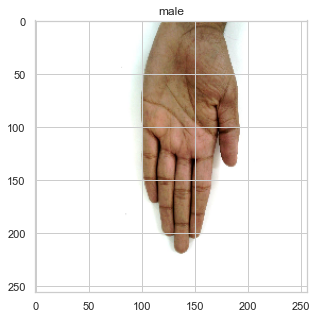

In [11]:
plt.figure(figsize = (5,5))
plt.imshow(data[0][0])
plt.title(data[0][1])

In [12]:
# Female = 4363
# Male   = 3967
# Total  = 8330
# Train  = 6247(F - 3272 | M - 2975)
# Test   = 2083(F - 1091 | M - 992)

In [13]:
m_classes = [1 if i == 'male' else 0 for i in classes_bal]
f_classes = [1 if i == 'female' else 0 for i in classes_bal]

In [32]:
x_train, x_test, y_train, y_test = train_test_split(data_bal, np.array(list(zip(m_classes, f_classes))), train_size=0.8, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, shuffle=True)

### Normalização

In [33]:
x_train = np.array([x[0] for x in x_train]) / 255
x_test = np.array([x[0] for x in x_test]) / 255
x_val = np.array([x[0] for x in x_val]) / 255

x_train.reshape(-1, img_size, img_size, 1)

x_test.reshape(-1, img_size, img_size, 1)

array([[[[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [0.90588235],
         [0.96862745],
         [1.        ]],

        [[1.        ],
         [1.        ],
         [0.98823529],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],

        ...,

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [0.48627451],
         [0.85882353],
         [0.69803922]],

        [[0.5254902 ],
         [0.85882353],
         [0.70588235],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]],

        [[1.        ],
         [1.        ],
         [1.        ],
         ...,
         [1.        ],
         [1.        ],
         [1.        ]]],


       [[[1.        ],
         [1.        ],
         [1.  

### Modelagem

In [34]:
model = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.summary()

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt , loss='categorical_crossentropy', metrics='accuracy')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)            

In [38]:
y_val[0]

array([0, 1])

In [35]:
history = model.fit(x_train, y_train, epochs=500, validation_data=(x_val, y_val))

Epoch 1/500


ValueError: in user code:

    C:\Users\danie\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:855 train_function  *
        return step_function(self, iterator)
    C:\Users\danie\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\danie\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\danie\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\danie\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\distribute\distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\danie\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:838 run_step  **
        outputs = model.train_step(data)
    C:\Users\danie\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\training.py:796 train_step
        loss = self.compiled_loss(
    C:\Users\danie\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\danie\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\danie\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\danie\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\danie\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\losses.py:1643 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\Users\danie\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\danie\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\backend.py:4862 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\danie\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 2) and (None, 10) are incompatible


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions, target_names = ['Male','Female']))